In [37]:
import pandas as pd
import os
TITANIC_PATH = os.path.join("datasets","titanic")
def load_titanic_data(filename, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, filename)
    return pd.read_csv(csv_path)

In [39]:
train_data = load_titanic_data("train.csv")
test_data = load_titanic_data("test.csv")

## Phân tích sơ bộ

In [42]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [44]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Cabin (77% rỗng) tạm thời bỏ qua Cabin và tập trung vào các thuộc tính còn lại.

Hai thuộc tính Name và Ticket có thể sẽ hữu ích, nhưng dạng loại này sẽ hơi khó để biến đổi chúng về dạng số để có thể đưa chúng vào mô hình nên tạm thờ bỏ qua hai thuộc tính này.

In [48]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


38% hành khách sống sót (nhãn Survived) gần với 40%, nên accuracy là phép đo phù hợp để đánh giá mô hình.

Giá vé (Fare) trung bình là 32.20 đơn vị Bảng Anh, Độ tuổi (Age) trung bình thấp hơn 30.

#### Xem qua các thuộc tính categorical

In [53]:
train_data["Survived"].value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

In [55]:
train_data["Pclass"].value_counts()

Pclass
3    491
1    216
2    184
Name: count, dtype: int64

In [57]:
train_data["Sex"].value_counts()

Sex
male      577
female    314
Name: count, dtype: int64

In [59]:
train_data["Embarked"].value_counts()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

## Preprocess data

In [62]:
numeric_features = ["Age", "SibSp", "Parch", "Fare"]
categorical_features = ["Pclass", "Sex", "Embarked"]

In [64]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X], index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)


num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

cat_pipeline = Pipeline([
    ("imputer", MostFrequentImputer()),
    ("onehot", OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ("num", num_pipeline, numeric_features),
    ("cat", cat_pipeline, categorical_features),
])


In [66]:
preprocessor.fit(train_data)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['Age', 'SibSp', 'Parch', 'Fare']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  MostFrequentImputer()),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Pclass', 'Sex', 'Embarked'])])

In [68]:
X_train = preprocessor.transform(train_data)
y_train = train_data["Survived"]

## Baseline Model, build quick model

In [71]:
from sklearn.svm import SVC
svm_clf = SVC(gamma="auto")
svm_clf.fit(X_train, y_train)

SVC(gamma='auto')

In [73]:
from sklearn.model_selection import cross_val_score

svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10,scoring="accuracy")
svm_scores.mean()

0.8249313358302123

In [74]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_clf.fit(X_train,y_train)

RandomForestClassifier(random_state=42)

In [77]:
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10,scoring="accuracy")
forest_scores.mean()

0.8092759051186016

# Feature engineering 

C:\Users\HO KHOI\AppData\Local\Temp\ipykernel_4112\479307322.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([svm_scores, forest_scores], labels=("SVM","Random Forest"))


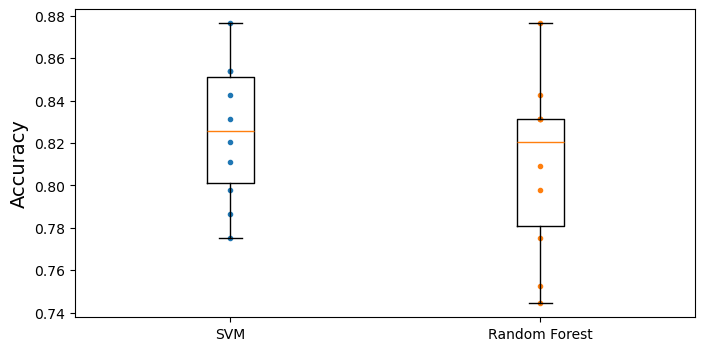

In [79]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.boxplot([svm_scores, forest_scores], labels=("SVM","Random Forest"))
plt.ylabel("Accuracy", fontsize=14)
plt.show()

##### 1. Xem xét khả năng sống sót của những người có người thân đi kèm và không có người thân đi kèm

In [82]:
train_data_eda = train_data.copy()

In [83]:
train_data_eda["RelativesOnboard"]= train_data["SibSp"] + train_data["Parch"]
train_data_eda.groupby("RelativesOnboard")["Survived"].mean()

RelativesOnboard
0     0.303538
1     0.552795
2     0.578431
3     0.724138
4     0.200000
5     0.136364
6     0.333333
7     0.000000
10    0.000000
Name: Survived, dtype: float64

-> Không có người thân đi kèm chỉ có 30% tỷ lệ sống sót, tạo một hạng mục dành riêng cho những hành khách du hành một mình, vì chỉ có 30% trong số họ sống sót -> cho thấy đi một mình khả năng sống sót cũng thấp

In [87]:
train_data_eda["IsAlone"] = (train_data_eda["RelativesOnboard"]==0)

##### 2. Các nhóm tuổi khác nhau có tỉ lệ sống sót rất khác nhau , nên việc sử dụng nhóm tuổi như hạng mục thay vì dùng trực tiếp tuổi có thể sẽ hữu ích

In [90]:
bins = [0, 15, 30, 45, 60, 75]
labels = ['Child', 'Teen', 'YoungAdult', 'Adult', 'Elder']
train_data_eda["AgeGroup"] = pd.cut(train_data_eda["Age"], bins=bins, labels=labels,include_lowest=True)

In [92]:
print("\nTỷ lệ sống sót theo AgeGroup:")
print(train_data_eda.groupby('AgeGroup')['Survived'].mean())


Tỷ lệ sống sót theo AgeGroup:
AgeGroup
Child         0.590361
Teen          0.358896
YoungAdult    0.425743
Adult         0.407407
Elder         0.190476
Name: Survived, dtype: float64


C:\Users\HO KHOI\AppData\Local\Temp\ipykernel_4112\2417510264.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(train_data_eda.groupby('AgeGroup')['Survived'].mean())


<Axes: xlabel='AgeGroup', ylabel='Count'>

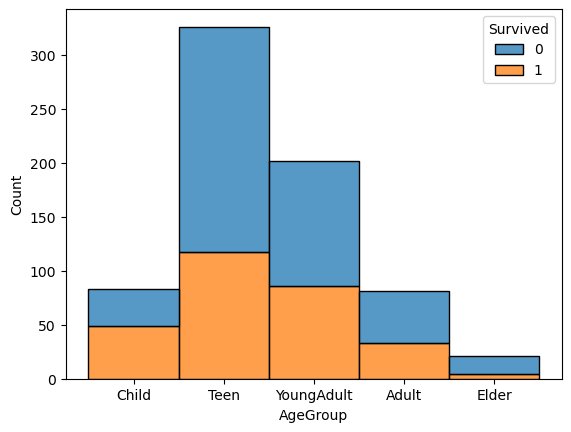

In [152]:
sns.histplot(data=train_data_eda, x="AgeGroup", hue="Survived", multiple="stack")

-> Cho thấy trẻ em thường được ưu tiên cứu hộ nên tỷ lệ sống sót cao, người già 75 tuổi trở đi tỷ lệ sống rất thấp

##### 3. Tiền tố trong tên cũng có thể tương quan đến tỷ lệ sống sót, như những bá tước, phụ nữ, quý bà,... có khả năng sống sót cao hơn

In [96]:
train_data_eda['Title'] = train_data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

<>:1: SyntaxWarning: invalid escape sequence '\.'
<>:1: SyntaxWarning: invalid escape sequence '\.'
C:\Users\HO KHOI\AppData\Local\Temp\ipykernel_4112\2589418899.py:1: SyntaxWarning: invalid escape sequence '\.'
  train_data_eda['Title'] = train_data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)


In [98]:
train_data_eda['Title'] = train_data_eda['Title'].replace('Mme', 'Mrs')
train_data_eda['Title'] = train_data_eda['Title'].replace(['Mlle', 'Ms'], 'Miss')
train_data_eda['Title'] = train_data_eda['Title'].replace(['Dr', 'Rev', 'Col', 'Major', 'Countess', 'Lady', 'Sir', 'Don', 'Jonkheer'], 'Rare')

In [100]:
# Kiểm tra tương quan Title với Survived
print("Tỷ lệ sống sót theo Title:")
print(train_data_eda.groupby('Title')['Survived'].mean())

Tỷ lệ sống sót theo Title:
Title
Capt      0.000000
Master    0.575000
Miss      0.702703
Mr        0.156673
Mrs       0.793651
Rare      0.363636
Name: Survived, dtype: float64


-> Phụ nữ nói chung (đã kết hôn và chưa kết hôn) có tỷ lệ sống sót cao hơn đàn ông

# Hiệu suất mô hình với những feature mới

In [104]:
from sklearn.base import BaseEstimator, TransformerMixin

class RelativesAndAloneTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_copy = X.copy()
        X_copy["RelativesOnboard"] = X_copy["SibSp"] + X_copy["Parch"]
        X_copy["IsAlone"] = (X_copy["RelativesOnboard"] == 0).astype(int)
        return X_copy

class AgeGroupTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_copy = X.copy()
        bins = [0, 15, 30, 45, 60, 75, float('inf')]
        labels = ['Child', 'Teen', 'YoungAdult', 'Adult', 'Elder', 'Unknown']
        X_copy["AgeGroup"] = pd.cut(X_copy["Age"], bins=bins, labels=labels, include_lowest=True)
        return X_copy

class TitleTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_copy = X.copy()
        X_copy['Title'] = X_copy['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)
        X_copy['Title'] = X_copy['Title'].replace('Mme', 'Mrs')
        X_copy['Title'] = X_copy['Title'].replace(['Mlle', 'Ms'], 'Miss')
        X_copy['Title'] = X_copy['Title'].replace(['Dr', 'Rev', 'Col', 'Major', 'Countess', 'Lady', 'Sir', 'Don', 'Jonkheer'], 'Rare')
        return X_copy

In [108]:
updated_numeric_features = ["Age", "Fare", "RelativesOnboard"]
updated_categorical_features = ["Pclass", "Sex", "Embarked", "IsAlone", "AgeGroup", "Title"]

num_data_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

cat_data_pipeline = Pipeline([
    ("imputer", MostFrequentImputer()),
    ("onehot", OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

feature_engineering_pipeline = Pipeline([
    ("relatives_and_alone", RelativesAndAloneTransformer()),
    ("age_group", AgeGroupTransformer()),
    ("title", TitleTransformer())
])
data_preprocessor = ColumnTransformer([
    ("num", num_data_pipeline, updated_numeric_features),
    ("cat", cat_data_pipeline, updated_categorical_features),
])
full_pipeline = Pipeline([
    ("feature_engineering", feature_engineering_pipeline),
    ("preprocessor", data_preprocessor)
])

In [110]:
full_pipeline.fit(train_data)

Pipeline(steps=[('feature_engineering',
                 Pipeline(steps=[('relatives_and_alone',
                                  RelativesAndAloneTransformer()),
                                 ('age_group', AgeGroupTransformer()),
                                 ('title', TitleTransformer())])),
                ('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Fare',
                                                   'RelativesOnboard']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   MostFrequentImputer()),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Pclass', 'Sex', 'Embarked',
                                                   'IsAlone', 'AgeGroup',
                                                   'Title'])]))])

In [112]:
X_train_new = full_pipeline.transform(train_data)
y_train_new = train_data["Survived"]

In [114]:
from sklearn.svm import SVC
svm_clf_2 = SVC(gamma="auto")
svm_clf_2.fit(X_train_new, y_train_new)

SVC(gamma='auto')

In [118]:
svm_scores = cross_val_score(svm_clf_2, X_train_new, y_train_new, cv=10,scoring="accuracy")
svm_scores.mean()

0.8350312109862671

-> Sau khi thực hiện tạo đặc trưng mới và trích chọn đặc trưng hữu dụng kết quả mô hình đã tốt hơn ~ 1.5%

In [137]:
from sklearn.model_selection import GridSearchCV


param_grid_svm = [
    {'kernel': ['rbf'], 'C': [1, 10, 100], 'gamma': ['scale', 'auto', 0.1, 0.01]},
    {'kernel': ['linear'], 'C': [1, 10, 100]},
]

# Tinh chỉnh SVM
grid_search_svm = GridSearchCV(SVC(), param_grid_svm, cv=5, scoring='accuracy')
grid_search_svm.fit(X_train_new, y_train_new)

print("Best SVM parameters:", grid_search_svm.best_params_)
print("Best SVM score:", grid_search_svm.best_score_)

Best SVM parameters: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Best SVM score: 0.8383717280773336


-> Sau khi tiến hành tìm kiếm ra bộ tham số tốt nhất, độ chính xác của mô hình là 0.8384 tăng lên ~ 0.02%